# BCNN for Fine Grained Analysis
In this notebook we will explore how to use deep learning for fine grained image classification using **BCCN(Bi-Linear CNN Model)**. We will use **Caltech-UCSD Birds 200** data set.  Here is the details on the dataset:

**Details:**
Caltech-UCSD Birds-200-2011 (CUB-200-2011) is an extended version of the CUB-200 dataset, with roughly double the number of images per class and new part location annotations. For detailed information about the dataset, please see the technical report linked below.

Number of categories: 200

Number of images: 11,788

Annotations per image: 15 Part Locations, 312 Binary Attributes, 1 Bounding Box

We will only use the classification data and try to compare **top 1 and top 5** results.

Lets start by installing **pytorch** and the dataset

## Install Libraries

In [0]:
!pip3 install torch torchvision

## Download Dataset

In [0]:
# Download data
!wget http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz

**Checking the downloaded data and uncompressing it**

In [0]:
!ls

CUB_200_2011.tgz  sample_data


In [0]:
# Uncompress files
!tar xvzf CUB_200_2011.tgz


**Check out the read me file to understand the data structure**

In [0]:
!cat CUB_200_2011/README

The Caltech-UCSD Birds-200-2011 Dataset

For more information about the dataset, visit the project website:

  http://www.vision.caltech.edu/visipedia

If you use the dataset in a publication, please cite the dataset in
the style described on the dataset website (see url above).

Directory Information
---------------------

- images/
    The images organized in subdirectories based on species. See 
    IMAGES AND CLASS LABELS section below for more info.
- parts/
    15 part locations per image. See PART LOCATIONS section below 
    for more info.
- attributes/
    322 binary attribute labels from MTurk workers. See ATTRIBUTE LABELS 
    section below for more info.



IMAGES AND CLASS LABELS:
Images are contained in the directory images/, with 200 subdirectories (one for each bird species)

------- List of image files (images.txt) ------
The list of image file names is contained in the file images.txt, with each line corresponding to one image:

<image_id> <image_name>
---------------

## Modelling

### Importing Required Libraries

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
import math

In [0]:
import torch
import torchvision

### Defining few helper functions

In [0]:
def read_image(path):
    im = Image.open(str(path))
    if im.getbands()[0] == 'L':
        im = im.convert('RGB')
    return im

In [0]:
# Data Augmentation
train_transforms = torchvision.transforms.Compose([
            torchvision.transforms.Resize(size=448),  # Let smaller edge match
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomCrop(size=448),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                             std=(0.229, 0.224, 0.225))
        ])
test_transforms = torchvision.transforms.Compose([
            torchvision.transforms.Resize(size=448),
            torchvision.transforms.CenterCrop(size=448),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                             std=(0.229, 0.224, 0.225))
        ])

In [0]:
def denormalize(img):
  imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
  return img*imagenet_stats[1] + imagenet_stats[0]

In [0]:
def show_image(img):
  img = img.numpy().transpose(1,2,0)
  img= denormalize(img)
  plt.imshow(img)


In [0]:
def visualize(dataloader, categories):
    """Imshow for Tensor."""
    x,y = next(iter(dataloader))
    
    fig = plt.figure(figsize=(10, 10))
    for i in range(8):
      inp = x[i]
      inp = inp.numpy().transpose(1,2,0)
      inp = denormalize(inp)
      
      ax = fig.add_subplot(2, 4, i+1, xticks=[], yticks=[])
      plt.imshow(inp)
      plt.title(str(categories[y[i]]))
      

The data set has following files which are important for creation of dataset:
1. **image_class_labels**:  It has labels for each image indexed by image id
2. **train_test_split**: It stored train test split marked by 1 and 0
3. **images**: It has mapping between image id and image name which signifies the stored path under image folder.
4. **classes**: It stores the class id and class name

In [0]:
PATH = Path('./CUB_200_2011')
labels = pd.read_csv(PATH/"image_class_labels.txt", header=None, sep=" ")
labels.columns = ["id", "label"]
labels.head(2)

,id,label
0,1,1
1,2,1


In [0]:
train_test = pd.read_csv(PATH/"train_test_split.txt", header=None, sep=" ")
train_test.columns = ["id", "is_train"]
train_test.head(2)

,id,is_train
0,1,0
1,2,1


In [0]:
images = pd.read_csv(PATH/"images.txt", header=None, sep=" ")
images.columns = ["id", "name"]
images.head(2)

,id,name
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...


In [0]:
classes = pd.read_csv(PATH/"classes.txt", header=None, sep=" ")
classes.columns = ["id", "class"]
classes.head(2)

,id,class
0,1,001.Black_footed_Albatross
1,2,002.Laysan_Albatross


In [0]:
categories = [x for x in classes["class"]]

### Creating DataSet
We will create a custom dataset class dervied from Dataset class in pytorch. We need `__init__`, `__len__` and `__getitem__` class so that we can get the data and label and can feed it to data loader for creating small batches for model to train on and make prediction.  We also **apply the necssary transformation** in this step.

In [0]:
class CUB(Dataset):
    def __init__(self, files_path, labels, train_test, image_name, train=True, 
                 transform=False):
      
        self.files_path = files_path
        self.labels = labels
        self.transform = transform
        self.train_test = train_test
        self.image_name = image_name
        
        if train:
          mask = self.train_test.is_train.values == 1
          
        else:
          mask = self.train_test.is_train.values == 0
        
        
        self.filenames = self.image_name.iloc[mask]
        self.labels = self.labels[mask]
        self.num_files = self.labels.shape[0]
       
      
        
    def __len__(self):
        return self.num_files
    
    def __getitem__(self, index):
        y = self.labels.iloc[index,1] - 1
        
        file_name = self.filenames.iloc[index, 1]
        path = self.files_path/'images'/file_name
        x = read_image(path)
        x = self.transform(x)
        return x,y

In [0]:
train_dataset = CUB(PATH, labels, train_test, images, train= True, transform= train_transforms)
valid_dataset = CUB(PATH, labels, train_test, images, train= False, transform= test_transforms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


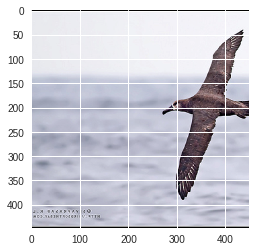

In [0]:
# If you get an error, restart the runtime
show_image(train_dataset[0][0])

In [0]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=64, num_workers=4)

**Lets visualize the model**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


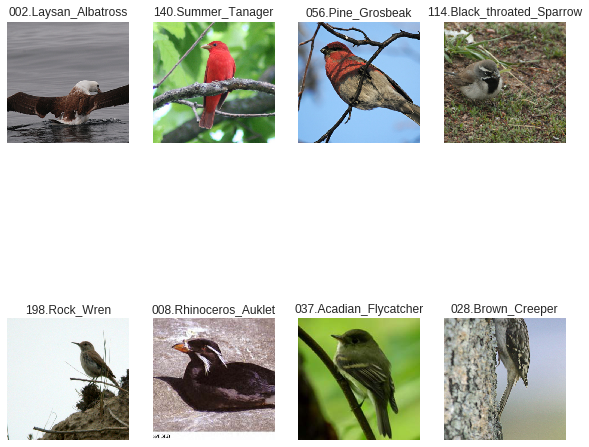

In [0]:
visualize(train_loader, categories)

In [0]:
x, y = next(iter(train_loader))
x.shape

torch.Size([64, 3, 448, 448])

### Define Model BCNN
**We will use VGG16 as the base architecture as suggested in the paper**

![title](http://vis-www.cs.umass.edu/bcnn/docs/teaser-bcnn.png)

**Network Architecture**<br>

**conv1^2 (64) -> pool1 -> conv2^2 (128) -> pool2 -> conv3^3 (256) -> pool3
    -> conv4^3 (512) -> pool4 -> conv5^3 (512) -> bilinear pooling
    -> sqrt-normalize -> L2-normalize -> fc (200) <br>
    The network accepts a 3*448*448 input, and the pool5 activation has shape
    512*28*28 since we down-sample 5 times.**

In [0]:
class BCNN(nn.Module):
    def __init__(self):
        super(BCNN, self).__init__()
        vgg16 = models.vgg16(pretrained=True)
        # freezing parameters
        for param in vgg16.parameters():
            param.requires_grad = False
        # convolutional layers of vgg16
        layers = list(vgg16.features.children())[:-1]
        self.features = nn.Sequential(*layers).cuda()
        self.fc = nn.Linear(512**2, 200)
        
        # Initialize the fc layers.
        nn.init.kaiming_normal(self.fc.weight.data)
        if self.fc.bias is not None:
            torch.nn.init.constant(self.fc.bias.data, val=0)

        
    def forward(self, x):
        N = x.size()[0]
        x = self.features(x)
        x = x.view(N, 512, 28**2)
        
        # Batch matrix multiplication
        x = torch.bmm(x, torch.transpose(x, 1, 2))/ (28**2) 
        x = x.view(N, 512**2)
        x = torch.sqrt(x+1e-5)
        x = F.normalize(x)
        x= self.fc(x)
        
        return x

### Traingular training policy:
Based on fast.ai, we will use one cycle traingular training policy to train the model. We first increase the learning rate from a low value for half of the cycle, and then decrease it which results in super convergence. For more, check out fast.ai blogs.

In [0]:
def get_triangular_lr(lr_low, lr_high, iterations):
  iter1 = int(0.35*iterations)
  iter2 = int(0.85*iter1)
  iter3 = iterations - iter1 - iter2
  delta1 = (lr_high - lr_low)/iter1
  delta2 = (lr_high - lr_low)/(iter1 -1)
  lrs1 = [lr_low + i*delta1 for i in range(iter1)]
  lrs2 = [lr_high - i*(delta1) for i in range(0, iter2)]
  delta3 = (lr_low - lr_low/10.0)/(iter3)
  lrs3 = [lrs2[-1] - i*(delta3) for i in range(1, iter3+1)]
  return lrs1+lrs2+lrs3


### Optimizer
We will use **SGD** as our optimizer

In [0]:
def get_optimizer(net, lr = 0.01, wd = 5e-4):
    parameters = filter(lambda p: p.requires_grad, net.parameters())
    optim = torch.optim.SGD(parameters, lr=lr, momentum=0.9, weight_decay=wd)
    return optim

### Learning Rate Finder
This functions helps us find the highest learning rate at which we can train the model. It has been dervied from fast.ai. Finding best learning rate is one of the most important step in trainin deep neural networks.

In [0]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=1, epochs=1, beta=0.9):
  losses = []
  # Model save path
  p = PATH/"mode_tmp.pth"
  save_model(model, str(p))
  num = len(train_dl)-1
  mult = (lr_high / lr_low) ** (1.0/num)
  lr = lr_low
  avg_loss = 0.
  best_loss = 0.
  batch_num = 0
  log_lrs = []

  model.train()
  for i in range(epochs):
    for x,y in train_dl:
      batch_num +=1
      optim = get_optimizer(model, lr=lr)
      x = x.cuda().float()
      y = y.cuda().long()   
      out = model(x)
      criterion = nn.CrossEntropyLoss()
      loss = criterion(out, y)

      #Compute the smoothed loss
      avg_loss = beta * avg_loss + (1-beta) *loss.item()
      smoothed_loss = avg_loss / (1 - beta**batch_num)

      #Stop if the loss is exploding
      if batch_num > 1 and smoothed_loss > 4 * best_loss:
        return log_lrs, losses

      #Record the best loss
      if smoothed_loss < best_loss or batch_num==1:
        best_loss = smoothed_loss
      #Store the values
      losses.append(smoothed_loss)
      log_lrs.append(math.log10(lr))

      optim.zero_grad()
      loss.backward()
      optim.step()
      #Update the lr for the next step
      lr *= mult
  load_model(model, str(p))
  return log_lrs, losses

### Traingular training policy:
Based on fast.ai, we will use one cycle traingular training policy to train the model. We first increase the learning rate from a low value for half of the cycle, and then decrease it which results in super convergence. For more, check out fast.ai blogs.

In [0]:
def train_triangular_policy(model, train_dl, valid_dl, lr_low=1e-5, 
                            lr_high=0.01, epochs = 4):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_triangular_lr(lr_low, lr_high, iterations)
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            optim = get_optimizer(model, lr = lrs[idx], wd =0)
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda().long()
            out = model(x)
            criterion = nn.CrossEntropyLoss()
            loss = criterion(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.item())
        print("train loss", sum_loss/total)
        val_metrics(model, valid_dl)
    return sum_loss/total

In [0]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y in valid_dl:
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda().long()
        out = model(x)
        _, pred = torch.max(out, 1)
        correct += pred.eq(y.data).sum().item()
        y = y.long()
        criterion = nn.CrossEntropyLoss()
        loss = criterion(out, y)
        sum_loss += batch*(loss.item())
        total += batch
    print("val loss and accuracy", sum_loss/total, correct/total)

In [0]:
from datetime import datetime

def training_loop(model, train_dl, valid_dl, steps=3, lr_low=1e-6, lr_high=0.01, epochs = 4):
    for i in range(steps):
        start = datetime.now() 
        loss = train_triangular_policy(model, train_dl, valid_dl, lr_low, lr_high, epochs)
        end = datetime.now()
        t = 'Time elapsed {}'.format(end - start)
        print("----End of step", t)

## Model training

In [0]:
model = BCNN().cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:15<00:00, 35928781.01it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  app.launch_new_instance()


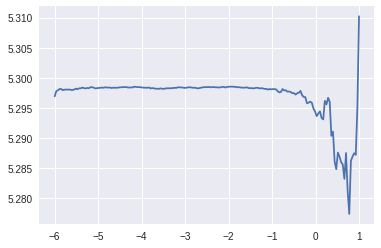

In [0]:
lrs, losses = LR_range_finder(model, train_loader, lr_low=1e-6, lr_high=10)
plt.plot(lrs, losses)
plt.show()

In [0]:
val_metrics(model, valid_loader)


val loss and accuracy 5.298316494201354 0.005005177770107007


In [0]:
training_loop(model, train_loader, valid_loader, steps=1, lr_low= 2, lr_high=3, epochs = 25)

train loss 5.257885393875219
val loss and accuracy 5.175500239509527 0.14118053158439764
train loss 5.123662061758108
val loss and accuracy 5.047470542122917 0.3201587849499482
train loss 4.9852562603013375
val loss and accuracy 4.916832128557041 0.39489126682775283
train loss 4.845253170988422
val loss and accuracy 4.784905558090026 0.42544011045909563
train loss 4.701974265926235
val loss and accuracy 4.651661233240298 0.4480497065930273
train loss 4.55693529652165
val loss and accuracy 4.518961401285284 0.49188816016568865
train loss 4.411930157734944
val loss and accuracy 4.383827832307246 0.5077666551605109
train loss 4.268066533374754
val loss and accuracy 4.249091560033259 0.5196755264066275
train loss 4.1208605519683905
val loss and accuracy 4.118784958714652 0.5452191922678633
train loss 3.982438571858016
val loss and accuracy 3.9932051618468734 0.581463583016914
train loss 3.847858458866785
val loss and accuracy 3.8805438466511557 0.5704176734552986
train loss 3.7264490079036

In [0]:
p = PATH/"model1_BCNN_tmp.pth"
save_model(model, str(p))
load_model(model, str(p))

In [0]:
training_loop(model, train_loader, valid_loader, steps=1, lr_low= 1.2, lr_high=2, epochs = 15)

train loss 2.894670169274728
val loss and accuracy 3.077234025737274 0.6719019675526406
train loss 2.855429577914961
val loss and accuracy 3.041536527870028 0.6724197445633414
train loss 2.820147896035735
val loss and accuracy 3.0025696163552773 0.6775975146703487
train loss 2.772285689900309
val loss and accuracy 2.962018856970985 0.6805315843976527
train loss 2.7310767956562825
val loss and accuracy 2.9190158912301847 0.6765619606489471
train loss 2.6784158488850536
val loss and accuracy 2.874408068721114 0.680013807386952
train loss 2.628760752456762
val loss and accuracy 2.8348582736533143 0.6817397307559544
train loss 2.585436099125299
val loss and accuracy 2.7994566201587605 0.6884708318950639
train loss 2.5455654944266164
val loss and accuracy 2.7685034851144006 0.687780462547463
train loss 2.512453177470862
val loss and accuracy 2.741512885865648 0.6896789782533655
train loss 2.4842020855930036
val loss and accuracy 2.7186239217534984 0.691404901622368
train loss 2.457392313100

In [0]:
training_loop(model, train_loader, valid_loader, steps=1, lr_low= 2, lr_high=2.5, epochs = 15)

train loss 1.9166534520563858
val loss and accuracy 2.2212915523816767 0.7143596824301001
train loss 1.8883634277451304
val loss and accuracy 2.1970038418939373 0.7129789437348981
train loss 1.8592042829499549
val loss and accuracy 2.173181780379601 0.7167759751467034
train loss 1.8271687123868559
val loss and accuracy 2.147369341846989 0.7172937521574042
train loss 1.797220947585744
val loss and accuracy 2.122321705880723 0.717811529168105
train loss 1.7702804022245817
val loss and accuracy 2.0967384713001405 0.7198826372109078
train loss 1.7380321136426242
val loss and accuracy 2.0731532788498876 0.7174663444943045
train loss 1.7116222043096283
val loss and accuracy 2.051220164983734 0.7186744908526062
train loss 1.68847805040854
val loss and accuracy 2.0305329626249287 0.7245426303072143
train loss 1.6649668429508024
val loss and accuracy 2.012483642312795 0.7205730065585088
train loss 1.639573076426048
val loss and accuracy 1.99633219713666 0.7243700379703141
train loss 1.626691834

In [0]:
def unfreeze_all(model):
  for p in model.parameters():
    p.requires_grad = True

In [0]:
training_loop(model, train_loader, valid_loader, steps=1, lr_low= 2, lr_high=2.5, epochs = 10)

train loss 1.5882079630722234
val loss and accuracy 1.948398972199545 0.7255781843286158
train loss 1.5672119096552963
val loss and accuracy 1.931247099210445 0.7273041076976182
train loss 1.5478697393510912
val loss and accuracy 1.9136827743008171 0.727131515360718
train loss 1.522966513205736
val loss and accuracy 1.8957280488848727 0.7286848463928202
train loss 1.502719754690642
val loss and accuracy 1.8777046118434397 0.7317915084570245
train loss 1.4865277428049464
val loss and accuracy 1.861764339072399 0.7324818778046255
train loss 1.470638136685511
val loss and accuracy 1.848004492760363 0.7311011391094235
train loss 1.444638254644873
val loss and accuracy 1.8373081747070854 0.7304107697618226
train loss 1.4345269901656212
val loss and accuracy 1.830198894873709 0.7311011391094235
train loss 1.4226274351139725
val loss and accuracy 1.8268233148813824 0.7305833620987228
----End of step Time elapsed 1:13:42.284461


In [0]:
training_loop(model, train_loader, valid_loader, steps=1, lr_low= 2, lr_high=2.5, epochs = 20)

train loss 1.426244134937957
val loss and accuracy 1.8152114182535763 0.7302381774249224
train loss 1.407162565806328
val loss and accuracy 1.800795621035796 0.7309285467725233
train loss 1.3961579024413844
val loss and accuracy 1.7881647594476264 0.732827062478426
train loss 1.3798466262158688
val loss and accuracy 1.7750612745871 0.7317915084570245
train loss 1.357605570946529
val loss and accuracy 1.7615560502235668 0.7343803935105281
train loss 1.3424342987654325
val loss and accuracy 1.7480959331409085 0.7354159475319296
train loss 1.3296998481492739
val loss and accuracy 1.7343655103315434 0.7374870555747325
train loss 1.3117162482834754
val loss and accuracy 1.721046067535116 0.7366240938902313
train loss 1.3010713729931587
val loss and accuracy 1.7094702785246365 0.7383500172592337
train loss 1.2816369618262138
val loss and accuracy 1.6963830583458486 0.7404211253020366
train loss 1.2653774303876044
val loss and accuracy 1.6850199652491744 0.7376596479116327
train loss 1.255738

In [0]:
training_loop(model, train_loader, valid_loader, steps=1, lr_low= 2, lr_high=2.5, epochs = 10)

train loss 1.181215223925568
val loss and accuracy 1.6186889425244133 0.74283741801864
train loss 1.1744167431219443
val loss and accuracy 1.609786985864465 0.742147048671039
train loss 1.1655168482809413
val loss and accuracy 1.6008312286160344 0.7411114946496375
train loss 1.1469481923717795
val loss and accuracy 1.5907180703093686 0.7416292716603383
train loss 1.138851275911799
val loss and accuracy 1.5811376945290188 0.7437003797031412
train loss 1.1277416134262468
val loss and accuracy 1.572302257845967 0.7450811183983431
train loss 1.1121558051607312
val loss and accuracy 1.5651040724075207 0.7445633413876424
train loss 1.1007897420091792
val loss and accuracy 1.5590104082760665 0.7461166724197446
train loss 1.0935513991135377
val loss and accuracy 1.5550638601456506 0.7464618570935451
train loss 1.0906440455952524
val loss and accuracy 1.5530963541517433 0.7461166724197446
----End of step Time elapsed 1:15:53.753360


In [0]:
training_loop(model, train_loader, valid_loader, steps=1, lr_low= 2.5, lr_high=3.5, epochs = 20)

train loss 1.093199245843006
val loss and accuracy 1.5451365066553997 0.7438729720400414
train loss 1.0807732492038955
val loss and accuracy 1.536398740196623 0.7445633413876424
train loss 1.0689512552282672
val loss and accuracy 1.5257397540322575 0.7455988954090439
train loss 1.0552285453419628
val loss and accuracy 1.5162276321746253 0.7426648256817397
train loss 1.0440636573730409
val loss and accuracy 1.506723369283021 0.7483603727994477
train loss 1.0339010327030191
val loss and accuracy 1.496162440351342 0.7476700034518468
train loss 1.0222612740717454
val loss and accuracy 1.4856709891613245 0.7490507421470487
train loss 1.002892851670424
val loss and accuracy 1.4751856208958625 0.7476700034518468
train loss 0.9963072903521426
val loss and accuracy 1.466974772006263 0.7459440800828443
train loss 0.9844357096675559
val loss and accuracy 1.4566987931502042 0.7480151881256473
train loss 0.9676279200487706
val loss and accuracy 1.4476666119660762 0.7481877804625474
train loss 0.957

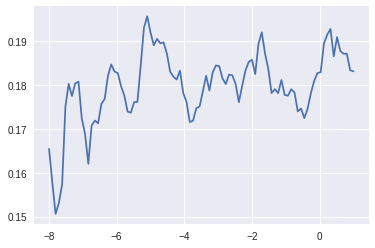

In [0]:
lrs, losses = LR_range_finder(model, train_loader, lr_low=1e-8, lr_high=10)
plt.plot(lrs, losses)
plt.show()

In [0]:
training_loop(model, train_loader, valid_loader, steps=1, lr_low= 4, lr_high=5, epochs = 10)

train loss 0.9061584335826102
val loss and accuracy 1.4003057497141072 0.7485329651363479
train loss 0.8999518845771048
val loss and accuracy 1.390842204098871 0.7499137038315499
train loss 0.8868739654670209
val loss and accuracy 1.3786752389799861 0.752847773558854
train loss 0.8728192410231989
val loss and accuracy 1.3686595962176786 0.750776665516051
train loss 0.8555340356018529
val loss and accuracy 1.360064110716417 0.754228512254056
train loss 0.8422013187273208
val loss and accuracy 1.34938623582572 0.752157404211253
train loss 0.8274272705341602
val loss and accuracy 1.3407891596190715 0.7533655505695547
train loss 0.815187268946065
val loss and accuracy 1.3336701102202457 0.7559544356230583
train loss 0.8066854700868751
val loss and accuracy 1.3291514044512458 0.7561270279599586
train loss 0.8012466066711778
val loss and accuracy 1.3270933245394532 0.7562996202968588
----End of step Time elapsed 1:16:30.724419


In [0]:
training_loop(model, train_loader, valid_loader, steps=1, lr_low= 7, lr_high=8, epochs = 10)

train loss 0.81188742852744
val loss and accuracy 1.3219952539694815 0.750776665516051
train loss 0.795375301553919
val loss and accuracy 1.311488100813305 0.7483603727994477
train loss 0.7777459488974677
val loss and accuracy 1.2984284263542696 0.7480151881256473
train loss 0.7560768658851519
val loss and accuracy 1.288964892425412 0.7525025888850535
train loss 0.7429585809663092
val loss and accuracy 1.273535092863742 0.7530203658957543
train loss 0.7220188982295004
val loss and accuracy 1.2613813363769197 0.7562996202968588
train loss 0.7126631203356448
val loss and accuracy 1.2502544232594954 0.7540559199171557
train loss 0.6914645618981905
val loss and accuracy 1.2405830452801814 0.7600966517086641
train loss 0.6788041887977022
val loss and accuracy 1.2349915939402818 0.7609596133931653
train loss 0.6720473887644333
val loss and accuracy 1.2317983223563191 0.7607870210562651
----End of step Time elapsed 1:16:34.804159


In [0]:
training_loop(model, train_loader, valid_loader, steps=1, lr_low= 7, lr_high=8, epochs = 10)

train loss 0.5785382862265285
val loss and accuracy 1.1635242460471085 0.7611322057300656
train loss 0.5753679253834663
val loss and accuracy 1.1564978406599649 0.7632033137728684
train loss 0.5669544001281123
val loss and accuracy 1.1505382482372648 0.762167759751467
train loss 0.5526018413377277
val loss and accuracy 1.145450837722432 0.7600966517086641
train loss 0.5415469791279024
val loss and accuracy 1.1393805028530577 0.7606144287193649
train loss 0.5317438869107195
val loss and accuracy 1.1330329878271799 0.7637210907835692
train loss 0.5186069256709662
val loss and accuracy 1.12638359292853 0.7616499827407663
train loss 0.515374469307609
val loss and accuracy 1.1205411469849957 0.7654470141525717
train loss 0.5086293194665485
val loss and accuracy 1.1164650786815942 0.768553676216776
train loss 0.4982679781115847
val loss and accuracy 1.114980549597518 0.7682084915429755
----End of step Time elapsed 1:16:28.909145


In [0]:
training_loop(model, train_loader, valid_loader, steps=1, lr_low= 7, lr_high=8, epochs = 10)

train loss 0.6721209754019448
val loss and accuracy 1.2285213018023313 0.7564722126337591
train loss 0.6635622596955514
val loss and accuracy 1.2213807010551876 0.752157404211253
train loss 0.6543006146495088
val loss and accuracy 1.2127068738382687 0.7597514670348636
train loss 0.6438851585418414
val loss and accuracy 1.2033490039251324 0.7587159130134622
train loss 0.6296903141983995
val loss and accuracy 1.1932931072678201 0.7638936831204695
train loss 0.6139878554267807
val loss and accuracy 1.1890780127661615 0.7576803589920608
train loss 0.6042652512972937
val loss and accuracy 1.1786258964239007 0.7587159130134622
train loss 0.5912237436245551
val loss and accuracy 1.1719067783490682 0.7640662754573697
train loss 0.5842425561285353
val loss and accuracy 1.1674844295269957 0.7626855367621678
train loss 0.573286611555734
val loss and accuracy 1.1650789291602726 0.76423886779427
----End of step Time elapsed 1:16:21.690195


In [0]:
training_loop(model, train_loader, valid_loader, steps=1, lr_low= 8, lr_high=10, epochs = 10)

train loss 0.49679936716705314
val loss and accuracy 1.1093014547814162 0.7666551605108733
train loss 0.4838637140817868
val loss and accuracy 1.1022723053791295 0.7645840524680704
train loss 0.4799875692403193
val loss and accuracy 1.098987083106688 0.7606144287193649
train loss 0.4718911229450384
val loss and accuracy 1.0936958892492743 0.7602692440455644
train loss 0.45669419213776435
val loss and accuracy 1.087564850618891 0.7640662754573697
train loss 0.45188433557380864
val loss and accuracy 1.0811062968102332 0.7664825681739731
train loss 0.44420343221805075
val loss and accuracy 1.076268655598719 0.76423886779427


In [0]:
training_loop(model, train_loader, valid_loader, steps=1, lr_low= 5, lr_high=7, epochs = 10)

train loss 0.4944073423310682
val loss and accuracy 1.1060059902212889 0.7659647911632723
train loss 0.488552841835512
val loss and accuracy 1.1021001242258075 0.7668277528477736
train loss 0.4863354184248068
val loss and accuracy 1.099187191021537 0.7654470141525717
train loss 0.4768330549294844
val loss and accuracy 1.0959427370916452 0.7651018294787711
train loss 0.4682171420928515
val loss and accuracy 1.0917236947955697 0.7659647911632723
train loss 0.4639754818903433
val loss and accuracy 1.0871233530278284 0.7676907145322748
train loss 0.45742471525579204
val loss and accuracy 1.0835789186525724 0.7676907145322748
train loss 0.45764178650197007
val loss and accuracy 1.0804294254971571 0.7680358992060753
train loss 0.4468875708761397
val loss and accuracy 1.0789371578290952 0.768553676216776
train loss 0.44229288416621604
val loss and accuracy 1.0780498479661096 0.767863306869175
----End of step Time elapsed 1:12:37.933170


In [0]:
training_loop(model, train_loader, valid_loader, steps=1, lr_low= 9, lr_high=11, epochs = 10)

train loss 0.44932636971628026
val loss and accuracy 1.0788004305142964 0.7630307214359683
train loss 0.4410282710133929
val loss and accuracy 1.0749749522765506 0.7651018294787711
train loss 0.43508184947568174
val loss and accuracy 1.0700421985939612 0.7683810838798757
train loss 0.4278539291989775
val loss and accuracy 1.0654572481980684 0.7644114601311702
train loss 0.4228620684401449
val loss and accuracy 1.0615535534411658 0.7661373835001726
train loss 0.40936399016294395
val loss and accuracy 1.0548870790033535 0.7663099758370728
train loss 0.40442535176768796
val loss and accuracy 1.0472951930351904 0.7668277528477736
train loss 0.39288409339176406
val loss and accuracy 1.0432426444530323 0.7668277528477736
train loss 0.3878881528173083
val loss and accuracy 1.0411982399906254 0.7670003451846737
train loss 0.38485214205674423
val loss and accuracy 1.0395433260195412 0.7673455298584743
----End of step Time elapsed 1:12:36.093101


In [0]:
training_loop(model, train_loader, valid_loader, steps=1, lr_low= 9, lr_high=11, epochs = 15)

train loss 0.3847619261708226
val loss and accuracy 1.0410825147232106 0.7652744218156714
train loss 0.3814311000777357
val loss and accuracy 1.0369535352099877 0.7670003451846737
train loss 0.37480432340054265
val loss and accuracy 1.0365462344722334 0.7645840524680704
train loss 0.3696095794091274
val loss and accuracy 1.0294799352046082 0.7670003451846737
train loss 0.3680404772013078
val loss and accuracy 1.0288564834382397 0.7626855367621678
train loss 0.35996619050885426
val loss and accuracy 1.0249778392770021 0.76423886779427
train loss 0.35006546544599104
val loss and accuracy 1.0182731528301918 0.7694166379012772
train loss 0.34411759750621096
val loss and accuracy 1.0168850713241993 0.7675181221953745
train loss 0.3433447405919656
val loss and accuracy 1.013888004157804 0.7711425612702796
train loss 0.33423244811949987
val loss and accuracy 1.010107818084377 0.7666551605108733
train loss 0.3314916074653844
val loss and accuracy 1.0051102681039819 0.7694166379012772
train los

In [0]:
training_loop(model, train_loader, valid_loader, steps=1, lr_low= .5, lr_high=2, epochs = 6)

train loss 0.3116961689463925
val loss and accuracy 0.9966807903649274 0.7714877459440801
train loss 0.30715132294633524
val loss and accuracy 0.9964745211156846 0.7699344149119779
train loss 0.30983068474062214
val loss and accuracy 0.9961647291738163 0.7706247842595789
train loss 0.3089598653155006
val loss and accuracy 0.9957297731359375 0.7711425612702796
train loss 0.3087579359760036
val loss and accuracy 0.9955924321833997 0.7713151536071798
train loss 0.306377070981103
val loss and accuracy 0.9954044542561163 0.7711425612702796
----End of step Time elapsed 0:43:39.461228


In [0]:
training_loop(model, train_loader, valid_loader, steps=1, lr_low= 10, lr_high=12, epochs = 5)

train loss 0.31872837051058117
val loss and accuracy 0.9971488165081802 0.7682084915429755
train loss 0.31300330138182614
val loss and accuracy 0.9948240013051782 0.7730410769761823
train loss 0.30726909562870786
val loss and accuracy 0.9893459395618327 0.7711425612702796
train loss 0.2959911355305641
val loss and accuracy 0.9862436027332632 0.7702795995857784
train loss 0.2923516933823332
val loss and accuracy 0.9835875062725237 0.7709699689333793
----End of step Time elapsed 0:36:19.004043


In [0]:
training_loop(model, train_loader, valid_loader, steps=1, lr_low= 15, lr_high=17, epochs = 10)

train loss 0.298898585695086
val loss and accuracy 0.9881244696005484 0.7663099758370728
train loss 0.2933957045441037
val loss and accuracy 0.9833792934427601 0.7707973765964791
train loss 0.2837177138945879
val loss and accuracy 0.9809692489471278 0.7675181221953745
train loss 0.28150076909108207
val loss and accuracy 0.9789467670812992 0.7659647911632723
train loss 0.2754303620961017
val loss and accuracy 0.978635067852522 0.768553676216776
train loss 0.2675475351286205
val loss and accuracy 0.969599949581112 0.7714877459440801
train loss 0.2619657594590017
val loss and accuracy 0.9657937480245412 0.7694166379012772
train loss 0.2562927765909099
val loss and accuracy 0.9597734851922749 0.772868484639282
train loss 0.246000422883877
val loss and accuracy 0.9563629575585513 0.7725232999654815
train loss 0.24422496957980994
val loss and accuracy 0.9550283754287525 0.7749395926820849
----End of step Time elapsed 1:12:30.736582


In [0]:
training_loop(model, train_loader, valid_loader, steps=1, lr_low= 15, lr_high=17, epochs = 15)

train loss 0.25003420702011775
val loss and accuracy 0.9592107848994355 0.7702795995857784
train loss 0.24369832932014326
val loss and accuracy 0.9589895619825943 0.768553676216776
train loss 0.24312784360435194
val loss and accuracy 0.9575681467487518 0.7675181221953745
train loss 0.23501371240512425
val loss and accuracy 0.9536023567494006 0.772178115291681
train loss 0.23132900809660967
val loss and accuracy 0.9515549489700428 0.7711425612702796
train loss 0.22967994937528402
val loss and accuracy 0.9474489067520073 0.7725232999654815
train loss 0.22375687058862145
val loss and accuracy 0.9441575065620365 0.7716603382809804
train loss 0.219613743034211
val loss and accuracy 0.9435124950940583 0.7709699689333793
train loss 0.2155529615240253
val loss and accuracy 0.93969298838993 0.7657921988263721
train loss 0.20965664716195695
val loss and accuracy 0.9368220651853402 0.7694166379012772
train loss 0.2072026597924498
val loss and accuracy 0.932989394948694 0.772178115291681
train los

In [0]:
training_loop(model, train_loader, valid_loader, steps=1, lr_low= , lr_high=7, epochs = 10)

train loss 0.1915530877279209
val loss and accuracy 0.9251013170203793 0.7745944080082844
train loss 0.19333571675402902
val loss and accuracy 0.9251414235394537 0.7737314463237832
train loss 0.18965511285526815
val loss and accuracy 0.9238640033338742 0.7747670003451846
train loss 0.18888498223201808
val loss and accuracy 0.9241569297536719 0.7723507076285813
train loss 0.18810213938688572
val loss and accuracy 0.9232411460708576 0.7726958923023818
train loss 0.18749852742021547
val loss and accuracy 0.9217677279139207 0.7752847773558854
train loss 0.18619446553386845
val loss and accuracy 0.9214126085428521 0.7739040386606835
train loss 0.18469499414528773
val loss and accuracy 0.920560579177302 0.7751121850189852
train loss 0.18427185374655483
val loss and accuracy 0.9201189233674895 0.7754573696927857
train loss 0.18156685176733378
val loss and accuracy 0.9198840496290706 0.7754573696927857
----End of step Time elapsed 1:12:36.364603


In [0]:
training_loop(model, train_loader, valid_loader, steps=1, lr_low = 1e-6, lr_high=1e-2, epochs = 15)

train loss 0.18248389074613064
val loss and accuracy 0.9198840716233285 0.7754573696927857
train loss 0.18130128804568174
val loss and accuracy 0.9198836420871983 0.7754573696927857
train loss 0.17989273926676375
val loss and accuracy 0.9198832327347605 0.7756299620296859
train loss 0.1819342665963464
val loss and accuracy 0.9198817586668369 0.7754573696927857
train loss 0.17952438916987407
val loss and accuracy 0.9198807642342183 0.7756299620296859
train loss 0.18259269872187453
val loss and accuracy 0.91988043664528 0.7756299620296859
train loss 0.17722763695894259
val loss and accuracy 0.919880151974978 0.7756299620296859
train loss 0.18137880649155363
val loss and accuracy 0.9198795143678182 0.7756299620296859
train loss 0.17998601505666484
val loss and accuracy 0.919878821682428 0.7756299620296859
train loss 0.18140484747645613
val loss and accuracy 0.919878701814751 0.7756299620296859
train loss 0.18039859813433867
val loss and accuracy 0.9198782954662061 0.7756299620296859
train

In [0]:
training_loop(model, train_loader, valid_loader, steps=1, lr_low = 10, lr_high=15, epochs = 15)

train loss 0.18403744655308582
val loss and accuracy 0.9221045894173453 0.7730410769761823
train loss 0.17981437038571826
val loss and accuracy 0.9203869458680158 0.7723507076285813
train loss 0.18261483704940373
val loss and accuracy 0.9186231953792421 0.7726958923023818
train loss 0.1805309222704735
val loss and accuracy 0.9196254950290637 0.772178115291681
train loss 0.17719734072048823
val loss and accuracy 0.9164958933447409 0.7756299620296859
train loss 0.17675503779141793
val loss and accuracy 0.9164002837705167 0.773558853986883
train loss 0.17281323787189143
val loss and accuracy 0.9157841341800841 0.7723507076285813
train loss 0.17506039994316655
val loss and accuracy 0.9138654716104567 0.773558853986883
train loss 0.17091125993180523
val loss and accuracy 0.9105220920758944 0.7740766309975837
train loss 0.16895549338401697
val loss and accuracy 0.9104810503790779 0.7730410769761823
train loss 0.16455704211930175
val loss and accuracy 0.9081381824372923 0.7733862616499827
tra

In [0]:
training_loop(model, train_loader, valid_loader, steps=1, lr_low = 10, lr_high=15, epochs = 15)

train loss 0.16095153136694076
val loss and accuracy 0.9058999101746111 0.7733862616499827
train loss 0.15705113917897454
val loss and accuracy 0.9044364424133696 0.7740766309975837
train loss 0.15645795738872068
val loss and accuracy 0.9057390726061166 0.7745944080082844
train loss 0.15867507328460484
val loss and accuracy 0.903721687935285 0.7756299620296859
train loss 0.158419605743539
val loss and accuracy 0.9037974316743805 0.7751121850189852
train loss 0.15514063802825875
val loss and accuracy 0.901329062027811 0.7739040386606835
train loss 0.14968669773500523
val loss and accuracy 0.900138653513889 0.7751121850189852
train loss 0.14846517062103665
val loss and accuracy 0.8985767272944939 0.773558853986883
train loss 0.148613827409329
val loss and accuracy 0.8984962840676102 0.7754573696927857
train loss 0.14412193638724727
val loss and accuracy 0.8982526827648586 0.772178115291681
train loss 0.14293944308876713
val loss and accuracy 0.8951395543888185 0.7740766309975837
train lo

In [0]:
p = "model1_BCNN_tmp4 (1) (4) (1) (5) (2).pth"
load_model(model, str(p))

## Accuracy Metrics:
The code below is dervied from Pytorch github [code](https://github.com/pytorch/examples/blob/master/imagenet/main.py)

In [0]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [0]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    #with torch.no_grad():
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [0]:
def calc_accuracy(model, dataloader):
    model.eval()
    model.cuda()    
    
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    for idx, (inputs, labels) in enumerate(dataloader):
        
        inputs, labels = inputs.cuda().float(), labels.cuda().long()
        # obtain the outputs from the model
        outputs = model.forward(inputs)
        prec1, prec5 = accuracy(outputs, labels, topk=(1, 5))
        top1.update(prec1[0], inputs.size(0))
        top5.update(prec5[0], inputs.size(0))
        
    return top1 ,top5
    

In [0]:
top1 ,top5 = calc_accuracy(model, valid_loader)

In [32]:
top1.avg

tensor(77.4767, device='cuda:0')

In [33]:
top5.avg

tensor(94.7877, device='cuda:0')

**We see a significant improvement in model performance from last model**

## Key Learnings
1. The model has a lot of parameters and training takes a lot of time.
2. The model requires a high learning rate to a magnitude not seen before, although LR finder suggest smaller rates
3. Model performance better than ResNet34 base model tried before
4. Large image size makes learning very slow

## Future Exploration
1. Reduce image size
2. Use ResNet
3. Reduce features